# Welcome to our Project!

## Goal of This Project: 
### We are continuing working on using regression modeling to make predictions based on our Zillow data of 2017 properties for single family homes. In this itteration of the project we are using clustering algorithms to aid us in determining similarites of the data. We are also shifting our focus to logerror rather than tax value.


## Project Plan
   

### Acquire and Prepare Data
   1. Data is brought in from either the SQL database using a locally stored env file that must contain the username, password, and host name in a get_bd_url function OR via a locally strored csv file.
   2. Data is prepared in order for our team to explore and modified to use in modeling
   3. Data is split into three dataframes called train, validate, and test so that we can train and explore on in-sample data and use out-of-sample to validate and finally test. 

### Exploration
   1. Use visualizations to see patterns in the data and try to determine drivers/indicators of logerror
   2. Use statistical testing, if necessary, to confirm or reject the relationship between features
   3. Use clustering to create new categorical features that can be explored 
   4. Determine what features align with logerror deviating significantly from zero

### Modeling
   1. Take features determined to be significant in exploration
   2. Determine which regression algorithm to use
   3. Run 4 models with chosen features and determine the best one by evaluating the RMSE score on the train set and run on the validate set
   4. The best model will be deterined by lowest RMSE on train, and lowest variance between the RMSE of train and validate
   5. Run the top single model on the test dataset
   6. Evaluate results

### Recommendations / What Comes Next
   1. Based on model evaluation of the test dataset make recommendations and predictions
   2. Recommendations will include...
   3. Further steps are...

### Imports

In [15]:
import wrangle as w
import explore as e
import wrangle_Naomi as wn
import model as m
import env

import pandas as pd
import numpy as np
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans

from importlib import reload
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Wrangling the Data (from SQL database using env file or local csv)
### For this we chose to initailly eliminate columns with more than 50% of the values being Null, and rows with anymore than 25% Null values. We also removed 'property county land use code' and 'property zoning desc' as they could not be converted from objects. Any further nulls were imputed with zero. We also made the data more human readable by changing the names of the columns.

In [11]:
#wrangling data and assigning it to a dataframe
df = w.wrangle_zillow()

In [12]:
# splitting data into three dataframes for training, validation, and testing
train, validate, test = w.tvt_split(df)

In [13]:
# shape of the three datasets
w.split_view(train, validate, test)
train_scaled = w.scale(train,['fireplace_count', 'latitude', 'longitude', 'tax_value', 'calc_sqft', 'log_error','pool_count','fips'])

train observations:  (43330, 19)
validate observations:  (18570, 19)
test observations:  (15475, 19)


## Data Dictionary



**Feature**|**Definition**|**Manipulation**|**Data Type**|
:-|:-|:-:|:-|
*calc_bath_and_bed*| The number of Bathrooms|Name change| float
*calc_sqft*| The square footage of the property| Name change | float
*fips* | The code of geographic location| Data Conversion| categorical
*fireplace_count*|The number of fireplaces on a property| Null values imputed as zero | float
*garage_car_count*| The number of cars a gargae can hold| Null values imputed as zero| float
*lot_sqft*| The square footage assigned to a property's exterior| Null values imputed as zero| float
*pool_count*| The number of pools on a property| Null values imputed as zero| float
*tax_value*| The dollar amount paid in taxes for the property| | Null values imputed as zero| float


# Exploration
## Our Thought Process:
   1. We began by taking a look at our train dataset in relation to our target vaiable, logerror.
   2. We then look to see what individial features tend to deviate significantly from zero logerror. 
   3. From looking at our features, we were able to generate four specific questions to ask of the data. 
   4. We used our human eyes and computer algorithms to create clusters which were tested against the target variable.
   5. We used visualizations and statistical tests to answer our questions. Sometimes the evaluation and answers lead to further questions. 
   

## Question One: Woody
### Can calculated square footage and tax value help predict log error

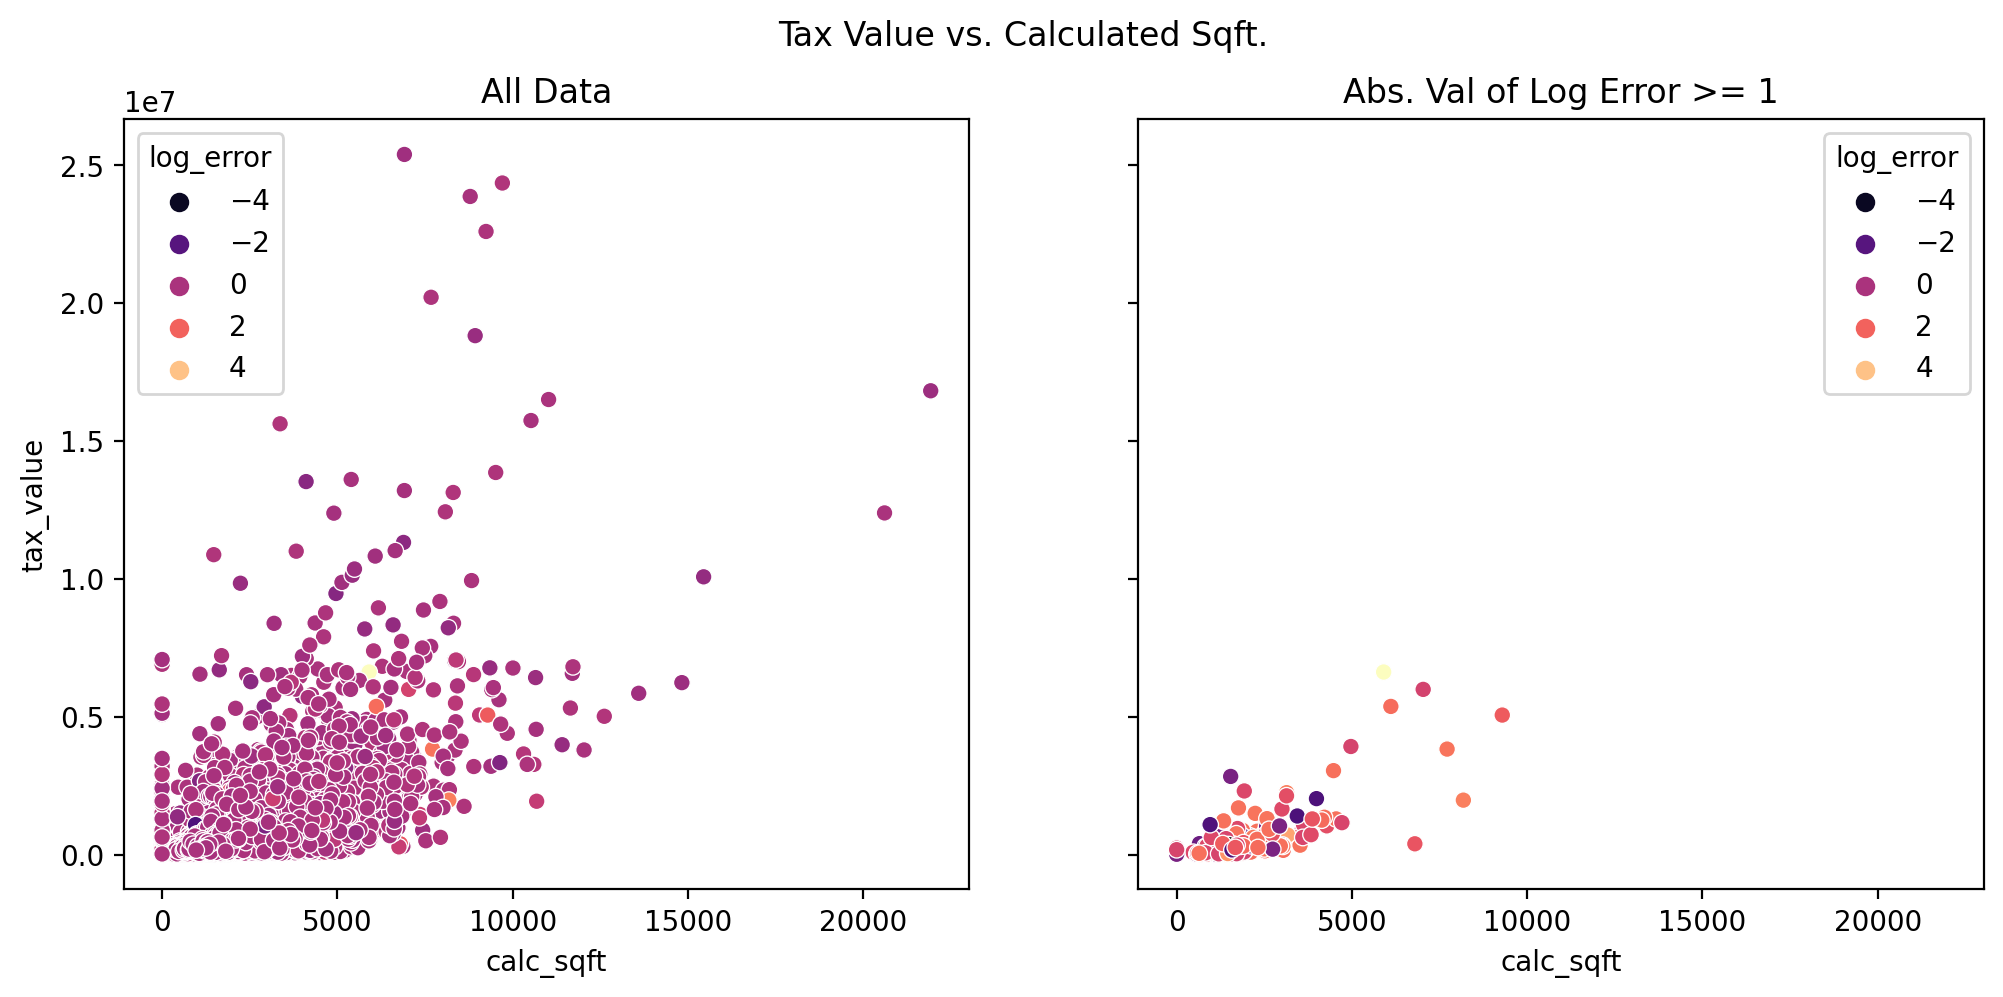

In [14]:
e.tax_sqft_plot(train)

### Based on this graph, we can conclude that there does appear to be a relationship between calculated square footage, tax value, and log errror

## Question Two: Woody
### Does clustering based on tax value and square footage result in statistically significant differences in each cluster's log error?

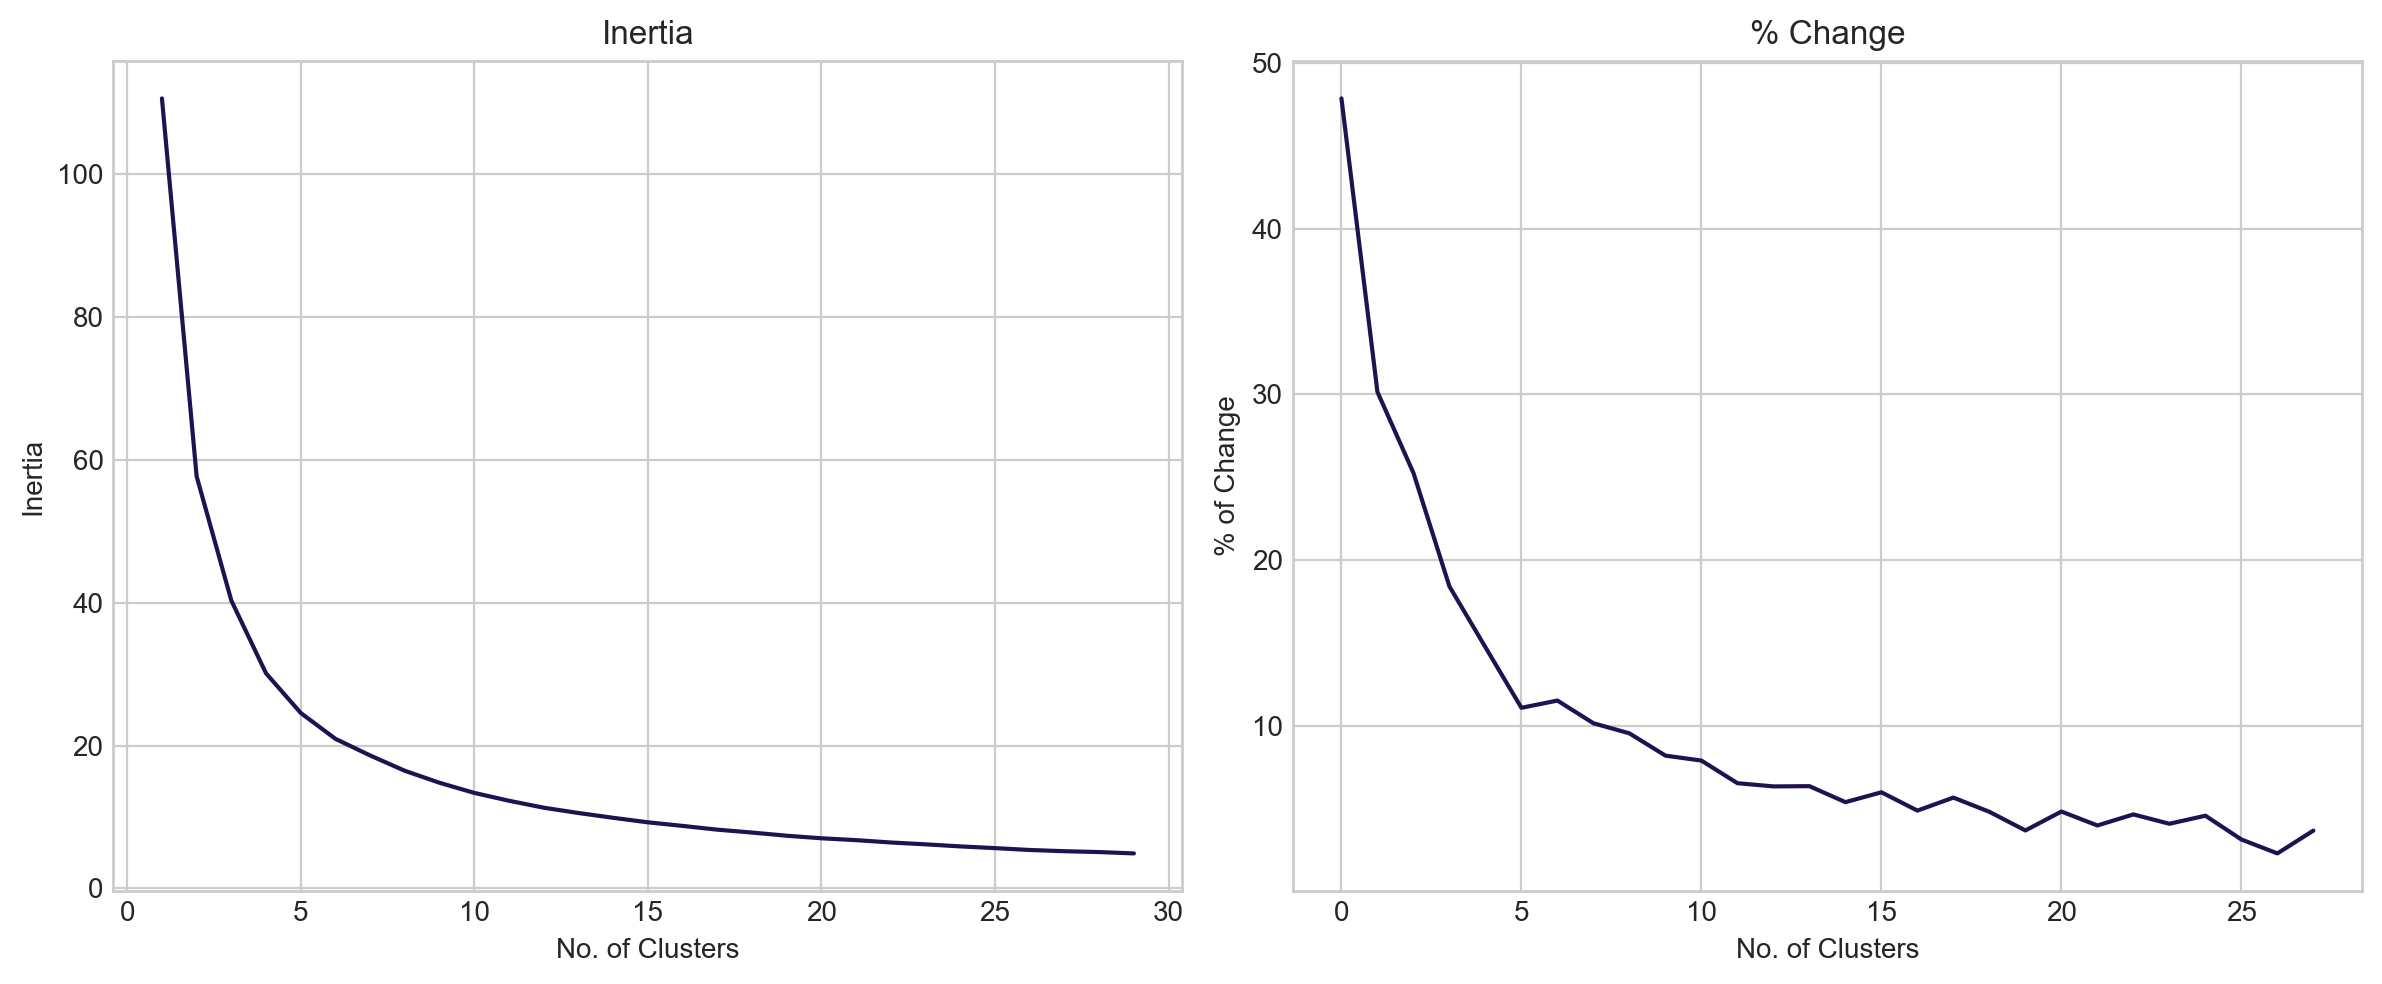

Index(['fireplace_count', 'latitude', 'longitude', 'tax_value', 'calc_sqft',
       'pool_count', 'fips', 'tax_sqft', 'log_error'],
      dtype='object')

In [35]:
reload(e)
train_scaled,scaler,kmeans = m.scale_and_cluster(train,['fireplace_count', 'latitude', 
    'longitude', 'tax_value', 'calc_sqft','pool_count','fips'],cluster_cols=['tax_value','calc_sqft'],cluster_name='tax_sqft',target='log_error',k=5)
e.generate_elbow(train_scaled[['calc_sqft','tax_value']])
train_scaled.columns


Question: is the mean log_error of items clustered by tax_value and calc_sqft significantly different from each other?

$H_0$: $\mu_{taxsqft0} = \mu_{taxsqft1}=$...$\mu_{taxsqft7}$

$H_a$: $\mu_{taxsqft0} \neq \mu_{taxsqft1} \neq $...$\neq \mu_{taxsqft7}$

## Assumptions
- Independent: Yep
- Normal: yes, Central Limit Theorum
- Equal variance:

In [36]:
train['tax_sqft_cluster'] = train_scaled.tax_sqft
train.groupby('tax_sqft_cluster').agg('var')[['log_error']]


,log_error
tax_sqft_cluster,
0,0.027380
1,0.056120
2,0.054468
3,0.028758
4,0.257244


In [42]:
samples = [train[train.tax_sqft_cluster == i].log_error for i in range(5)]
t,p = stats.levene(samples[0],samples[1],samples[2],samples[3],samples[4])
e.p_to_md(p,t)

## Because $\alpha$ > p,we  reject $H_0$

## Because the ranges of variance are so wide, we will use the non-parametric test

In [43]:
group_list = [train[train.tax_sqft_cluster == x].log_error.to_numpy() for x in range(4)]
t,p = stats.f_oneway(group_list[0],group_list[1],group_list[2],group_list[3])
e.t_to_md(t,p)

## t = 0.020067827913729592 

 ## p = 3.2770035249635505 

## Because t > 0 and $\alpha$ < p, we failed to   reject $H_0$

## However, given that there is such a strong cluster of these values based on tax value and square footage, we will move forward with the clusters as regression models

## Question Three:
### Will making a cluster of what my human eyes determine to be valuable out-door features help determine houses with significantly higher or lower logerror?

#### Valuable out-door features are garage count, pool count, and lot size

In [ ]:
train_scaled3 = wn.scaled_3(train)

In [ ]:
e.elbow_for_Q3(train_scaled3)

In [ ]:
wn.viz_for_Q3(train)

In [ ]:
wn.anova_test(train, 'cluster3')

In [ ]:
wn.anova_test(train_scaled3, 'cluster3_scaled')

<div class="alert alert-block alert-danger">
<b>  Takeaway:
    Based on the anova test we must conceed that there is no relationship between the cluster of features and log error. 
</div>

## Question Four:
### Is there a relationship between features that consistently have at least one cluster around zero log error?

#### To answer this we ran a really long loop that built four clusters around every pair of unique features and took note of when one or more clusters were centered around center of the y-axis which denoted a zero logerror. We highlighted features that reoccured and considered them for future exploration. 

In [ ]:
# THIS SPACE IS FOR THE LOOP

In [ ]:
# THIS SPACE IS FOR THE T-TEST

THIS IS FOR THE TAKEAWAY